<a href="https://colab.research.google.com/github/naoya1110/nitkc-ncku-ai-robotics/blob/main/Week06_Practical_Tips_for_Training_CNNs_pbartest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this week we are going to learn about practical techniques for training convolutional neural network (CNN) models including


*   Data Standardization
*   Data Augmentation
*   Dropout Layer



 As we have seen last week deep neural network models including CNNs can easily fall into the overfit state. So we always have to be careful about the models not to be overfitted during the training. However thanks to the intensive researches in this field, a lot of practical techniques that are effective for avoiding overfitting are already developed. In this notebook we are going to implement some of those techniques and see how they work.

**GPU**

We will need a GPU to train CNN models, so please make sure your runtime type is GPU (cuda).

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


**General Packages**

Then let's import some general Python packages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Data Preparation

**CIFAR10**

We will use CIFAR10 dataset again.

In [3]:
from torchvision.datasets import CIFAR10

xy_train = CIFAR10(root="cifar10", train=True, download=True)
xy_test = CIFAR10(root="cifar10", train=False, download=True)

classnames = {0:"plane", 
              1:"car", 
              2:"bird", 
              3:"cat", 
              4:"deer",
              5:"dog", 
              6:"frog", 
              7:"horse",
              8:"ship",
              9:"truck"}

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified


**Rescaling Data (Standardization, z-score normalization)**

Data rescaling is often performed as a preprocessing step before training. One of the data rescaling methods is standardization (aka. z-score normalization). The standardized data $z_i$ is converted from the raw data $x_i$ by the equation below, where $\mu$ and $\sigma$ are mean and standard deviation of all raw data, respectively.

$\displaystyle z_i=\dfrac{x_i-\mu}{\sigma}$ 

The mean and the standard deviation of the standardized data will be 0 and 1 respectively.

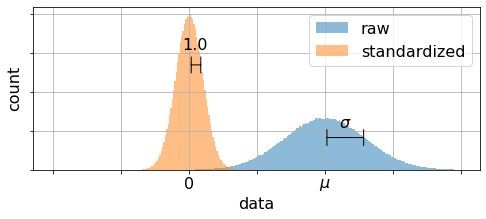

In order to standardize CIFAR10 image data, we need to know means $\mu$ and standard deviations $\sigma$ of red, green, blue pixels in training data. To do this, first we collect all red, green and blue pixels data in numpy arrays.

In [4]:
red_pixels = []
green_pixels = []
blue_pixels = []

for image, label in tqdm(xy_train):
    image = np.array(image)/255.     # normalize data from 0-255 to 0.0-1.0
    image = image.astype("float32")

    red_pixels.append(image[:,:,0])     # red pixels
    green_pixels.append(image[:,:,1])   # green pixels
    blue_pixels.append(image[:,:,2])    # blue pixels

# convert data to 1D array
red_pixels = np.array(red_pixels).flatten()
green_pixels = np.array(green_pixels).flatten()
blue_pixels = np.array(blue_pixels).flatten()

print("red pixels", red_pixels.shape)
print("green pixels", green_pixels.shape)
print("blue pixels", blue_pixels.shape)

  0%|          | 0/50000 [00:00<?, ?it/s]

red pixels (51200000,)
green pixels (51200000,)
blue pixels (51200000,)


Let's take a look at their distributions.

(array([1551988., 2281534., 2971214., 3189966., 3747945., 3881195.,
        3823561., 3368245., 3428782., 3141754., 2837695., 2386688.,
        2341215., 2117185., 1936989., 1645889., 1617958., 1472561.,
        1328403., 2129233.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

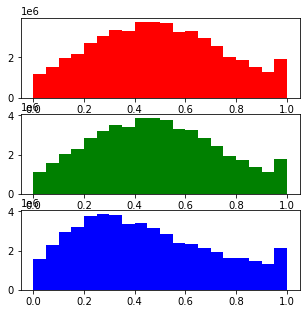

In [5]:
plt.figure(figsize=(5, 5))

bins = np.arange(0, 1.01, 0.05)

plt.subplot(3, 1, 1)
plt.hist(red_pixels, bins=bins, color="r")

plt.subplot(3, 1, 2)
plt.hist(green_pixels, bins=bins, color="g")

plt.subplot(3, 1, 3)
plt.hist(blue_pixels, bins=bins, color="b")

Now we can determine means of red, green and blue pixels.

In [6]:
means = (red_pixels.mean(), green_pixels.mean(), blue_pixels.mean())
means

(0.49139968, 0.48215827, 0.44653124)

Also standard deviations of red, green and blue pixels.

In [7]:
stds = (red_pixels.std(), green_pixels.std(), blue_pixels.std())
stds

(0.24703233, 0.24348505, 0.26158768)

Then we can standardize the raw data by using `means` and `stds` data, and see how the standardized data distributes.

(array([      0.,       0.,       0.,       0.,       0.,       0.,
         898852., 1966181., 2732543., 3569531., 3693052., 3868509.,
        4139301., 3673354., 3447925., 3396936., 2837695., 2575272.,
        2490425., 2086986., 1916065., 1876472., 1569945., 1423793.,
        1400024., 1637139.,       0.,       0.,       0.,       0.]),
 array([-3.00000000e+00, -2.80000000e+00, -2.60000000e+00, -2.40000000e+00,
        -2.20000000e+00, -2.00000000e+00, -1.80000000e+00, -1.60000000e+00,
        -1.40000000e+00, -1.20000000e+00, -1.00000000e+00, -8.00000000e-01,
        -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,  2.66453526e-15,
         2.00000000e-01,  4.00000000e-01,  6.00000000e-01,  8.00000000e-01,
         1.00000000e+00,  1.20000000e+00,  1.40000000e+00,  1.60000000e+00,
         1.80000000e+00,  2.00000000e+00,  2.20000000e+00,  2.40000000e+00,
         2.60000000e+00,  2.80000000e+00,  3.00000000e+00]),
 <a list of 30 Patch objects>)

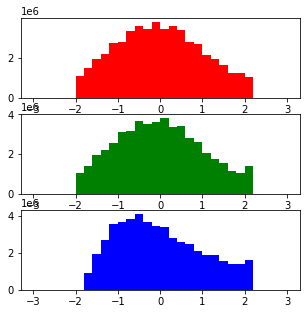

In [8]:
# standardization
red_pixels_z = (red_pixels-means[0])/stds[0]
green_pixels_z = (green_pixels-means[1])/stds[1]
blue_pixels_z = (blue_pixels-means[2])/stds[2]

# visualize distributions
plt.figure(figsize=(5, 5))

bins=np.arange(-3,3.1,0.2)

plt.subplot(3, 1, 1)
plt.hist(red_pixels_z, bins=bins, color="r")

plt.subplot(3, 1, 2)
plt.hist(green_pixels_z, bins=bins, color="g")

plt.subplot(3, 1, 3)
plt.hist(blue_pixels_z, bins=bins, color="b")

We will use the `means` and `stds` data later when we reload the CIFAR10 data as `torch.tensor` format.

**Data Augmentation**

Another technique that is often used as a preprocessing step is data augmentation. Data augmentation is very powerful for avoiding the model being overfitted especially when number of training data is limited. In each training epoch, slightly modified copies of images are generated from original images and those copies will be used for training.This is effective to prevent the model from just remembering training data because the model will never see exactly same data. The data augmention can be implemented very easily by using `torchvision.transforms` module.

Here we take one image from training data and let's see how this image can be augmented.

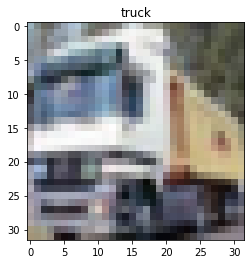

In [9]:
image, label = xy_train[1]
plt.imshow(image)
plt.title(classnames[label])

x = image

Random Horizontal Flip



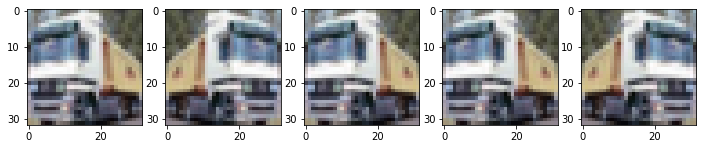

In [10]:
from torchvision import transforms
transform = transforms.RandomHorizontalFlip(p=0.5)

def show_transformed_images(transform, x):
    plt.figure(figsize=(12, 3))
    for i in range(5):
        output_image = transform(x)
        plt.subplot(1, 5, i+1)
        plt.imshow(output_image)

show_transformed_images(transform, x)

Random Vertical Flip

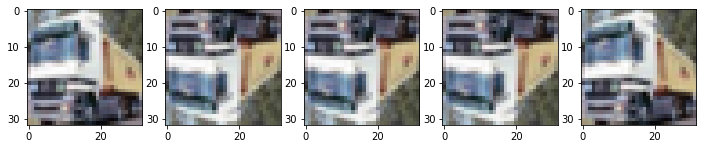

In [11]:
transform = transforms.RandomVerticalFlip(p=0.5)

show_transformed_images(transform, x)

Random Roation

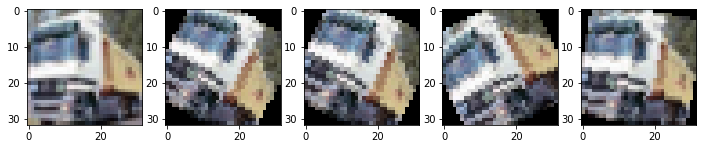

In [12]:
transform = transforms.RandomRotation(degrees=30)

show_transformed_images(transform, x)

Random Perspective

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


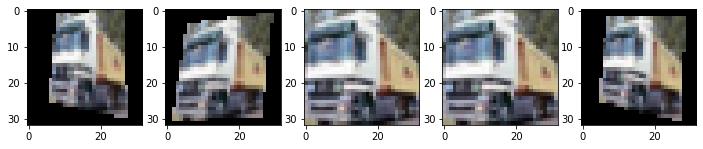

In [13]:
transform = transforms.RandomPerspective(distortion_scale=0.5, p=0.5)

show_transformed_images(transform, x)

We can combine several different transoforms by using `transform.Compose()`.

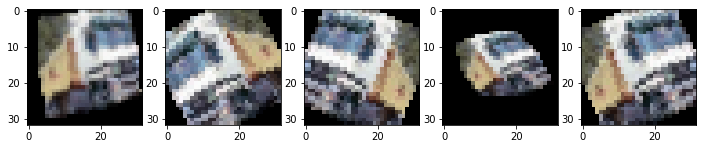

In [14]:
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(degrees=30),
                                transforms.RandomPerspective(distortion_scale=0.5, p=0.5)
])

show_transformed_images(transform, x)

There are lots of other transforms' modules that can be used for data augmentation. Please refer the information below.

`torchvision.transforms` https://pytorch.org/vision/stable/transforms.html

**Reload Data**

Now we reload CIFAR10 dataset in `torch.tensor` format. At the same time we enable the data standardization and the data augmentation. The standardization should be enabled for testing data too, but data augmentation should not.

In [15]:
from torchvision import transforms

xy_train = CIFAR10(root="cifar10", train=True, download=False, 
                   transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(means, stds), 
                                                  transforms.RandomRotation(degrees=10), 
                                                  transforms.RandomHorizontalFlip(p=0.5),
                                                  transforms.RandomPerspective(distortion_scale=0.5, p=0.5)
                                                  ])
                   )
                   
xy_test = CIFAR10(root="cifar10", train=False, download=False,
                   transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(means, stds)
                                                  ])
                   )

**Data Loader**

Then we create `DataLoader` objects for feeding data to the model. This is exactly same as we did with Iris dataset.

In [16]:
from torch.utils.data import DataLoader

train_loader = DataLoader(xy_train, batch_size=32, shuffle=True)
test_loader = DataLoader(xy_test, batch_size=32, shuffle=False)

That's it for data preparation!

# Model Building

**Model Architecture**

Next step is to build a convolutional neural network (CNN) and load it to GPU.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128*8*8, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),    # add a dropout layer
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)  
        return x
    
model = Model().to(device)
print(model)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


**Dropout Layer**

The model we defined here is identical to one we used last week, except for the dropout layer in the classifier. The dropout layer zeros some of input nodes randomly with the probability of `p` during training. Since less information will be propageted through the dropout layer, the model will be trained under more difficult condition. This will make the model more rubust.

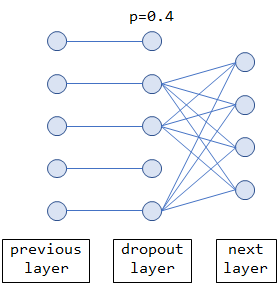

The dropout layer can be implemented with `nn.Dropout()`. The parameter `p` indicates the probabitlty of nodes to be 0 with a Bernoulli distribution. Also non-zero nodes will be scaled by a factor of 1/(1-p).

`nn.Dropout()` https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

In [18]:
x = torch.ones(10)
y = nn.Dropout(p=0.3)(x)
print(y)

tensor([1.4286, 1.4286, 0.0000, 1.4286, 1.4286, 1.4286, 1.4286, 0.0000, 1.4286,
        1.4286])


Let's see the model archtecture.

In [19]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

torch.Size([32, 3, 32, 32])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Sequential: 1-1                        [32, 128, 8, 8]           --
│    └─Conv2d: 2-1                       [32, 64, 32, 32]          1,792
│    └─ReLU: 2-2                         [32, 64, 32, 32]          --
│    └─MaxPool2d: 2-3                    [32, 64, 16, 16]          --
│    └─Conv2d: 2-4                       [32, 128, 16, 16]         73,856
│    └─ReLU: 2-5                         [32, 128, 16, 16]         --
│    └─MaxPool2d: 2-6                    [32, 128, 8, 8]           --
├─Sequential: 1-2                        [32, 10]                  --
│    └─Linear: 2-7                       [32, 256]                 2,097,408
│    └─ReLU: 2-8                         [32, 256]                 --
│    └─Dropout: 2-9                      [32, 256]                 --
│    └─Linear: 2-10                      [32, 10]                  2,57

# Training

**Loss Function**

We use the cross-entropy loss as the loss function since this is a classification task.

In [20]:
loss_func = nn.CrossEntropyLoss()

**Optimizer**

We use the Adam optimizer.

In [21]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

**Training Loop**

Now we train the model. This time we save the model after each epoch if the test accuracy is better than before. Then later we can load the best model.







In [25]:
epochs = 10
best_model_path = 'best_model.pth'
best_accuracy = 0.0

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader
        
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
    
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(test_loader)
        pbar.set_description("Test") 

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            test_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count/len(xy_train)   # determine accuracy for training data
    test_accuracy = test_correct_count/len(xy_test)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)            # determine loss for training data
    test_loss = test_loss/len(test_loader)               # determine loss for test data 

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    # save the model if test accuracy is better than before
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), best_model_path)
        print(f"Test accuracy improved from {best_accuracy:.3f} to {test_accuracy:.3f}")
        print(f"Model saved at {best_model_path}")
        best_accuracy = test_accuracy

-----------------------------
Epoch 1/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.603 Loss=1.124, Test: Accuracy=0.694 Loss=0.878
Test accuracy improved from 0.000 to 0.694
Model saved at best_model.pth
-----------------------------
Epoch 2/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.613 Loss=1.097, Test: Accuracy=0.690 Loss=0.900
-----------------------------
Epoch 3/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.624 Loss=1.070, Test: Accuracy=0.702 Loss=0.845
Test accuracy improved from 0.694 to 0.702
Model saved at best_model.pth
-----------------------------
Epoch 4/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.628 Loss=1.052, Test: Accuracy=0.716 Loss=0.820
Test accuracy improved from 0.702 to 0.716
Model saved at best_model.pth
-----------------------------
Epoch 5/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.634 Loss=1.042, Test: Accuracy=0.723 Loss=0.809
Test accuracy improved from 0.716 to 0.723
Model saved at best_model.pth
-----------------------------
Epoch 6/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.640 Loss=1.025, Test: Accuracy=0.714 Loss=0.807
-----------------------------
Epoch 7/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.642 Loss=1.016, Test: Accuracy=0.728 Loss=0.775
Test accuracy improved from 0.723 to 0.728
Model saved at best_model.pth
-----------------------------
Epoch 8/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.650 Loss=1.001, Test: Accuracy=0.734 Loss=0.775
Test accuracy improved from 0.728 to 0.734
Model saved at best_model.pth
-----------------------------
Epoch 9/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.650 Loss=1.000, Test: Accuracy=0.735 Loss=0.768
Test accuracy improved from 0.734 to 0.735
Model saved at best_model.pth
-----------------------------
Epoch 10/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.655 Loss=0.988, Test: Accuracy=0.728 Loss=0.783


**Learning Curves**

Let's visualize the accuracy and the loss curves for train and test data.

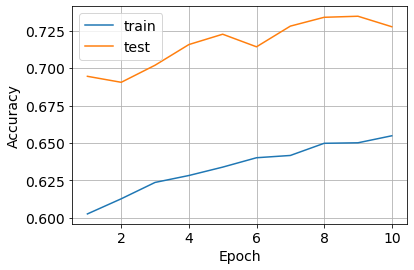

In [26]:
plt.rcParams["font.size"]=14
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, test_accuracy_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

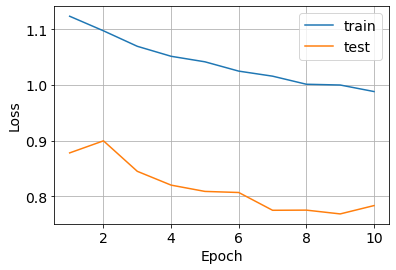

In [27]:
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, test_loss_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

As you see above, the test accuracy keeps increasing up to at least 10 epochs and is still higher than the train accuracy. Similarly the test loss keeps decreasing up to at least 10 epochs and still lower than the test loss. This indicates the model is not overfitted yet. Therefore we can continue to train the model until we see the overfitting.

# Evaluation

**Load the Best Model**

Now we can load the best model.

In [28]:
model = Model().to(device)
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

**Test Accuracy**

We should check accuracy of the model for all of the test data.

In [29]:
test_accuracy = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():    # disable autograd
    model.eval()         # set model to evaluation mode
    
    for x_batch, y_batch in test_loader:    # take mini batch data from train_loader
        x_batch = x_batch.to(device)        # transfer x_batch to gpu
        y_batch = y_batch.to(device)        # transfer y_batch to gpu
        p_batch = model(x_batch)            # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)       # convert p_batch vector to p_batch_label
        test_accuracy += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.to("cpu").numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())  # append p_batch_label in p_label_all

test_accuracy = test_accuracy/len(xy_test)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

Test Accuracy = 0.735


**Confusion Matrix**

Then let's check the confusion matrix.

Text(0.5, 1.0, 'confusion matrix')

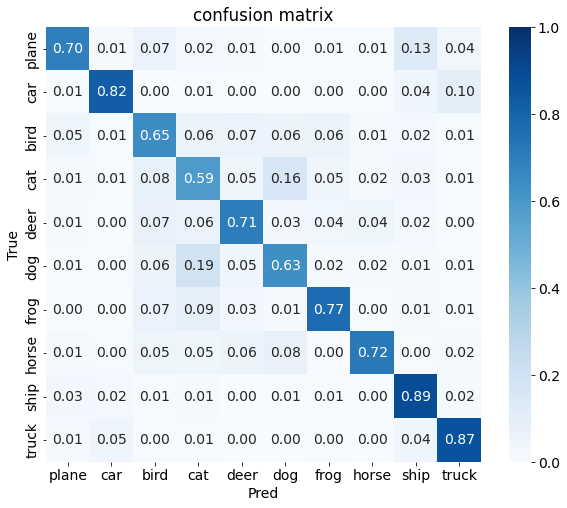

In [30]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(10,8))
labels = classnames.values()

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=classnames.values(), yticklabels=classnames.values(), square=True)

plt.ylabel("True")
plt.xlabel("Pred")
plt.title("confusion matrix")

**Predictions for Test Data**

Let's see predictions for some test data.

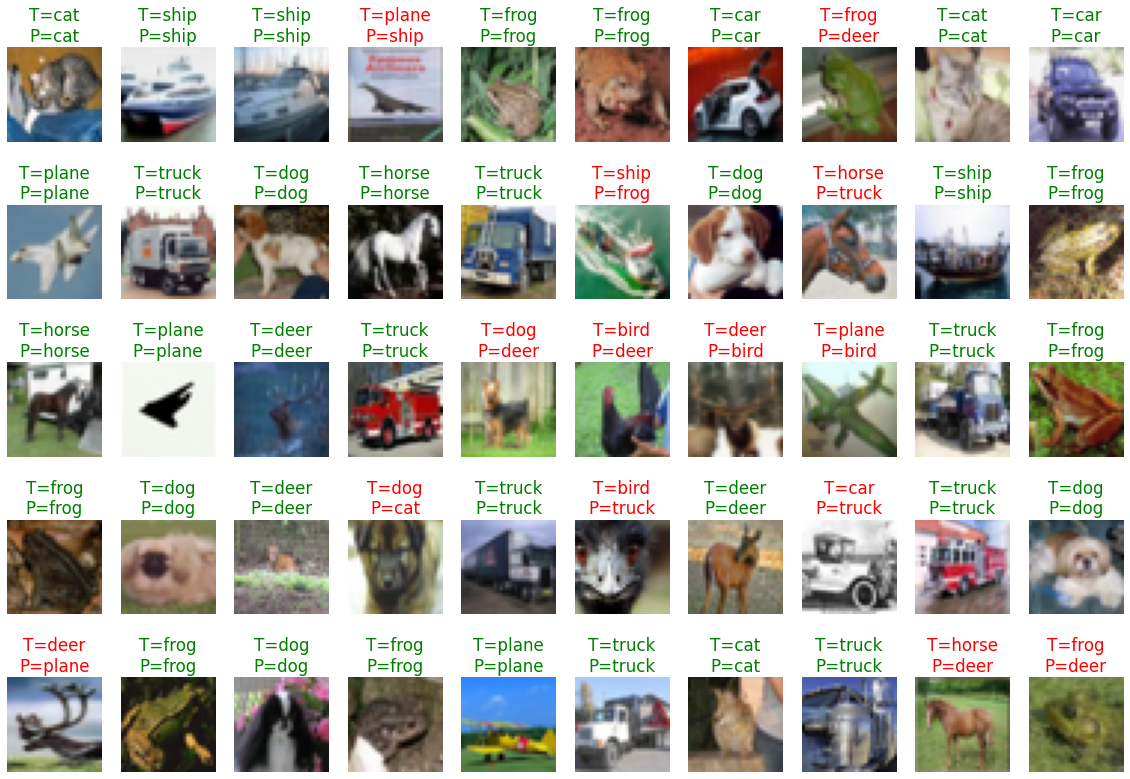

In [36]:
plt.figure(figsize=(20, 14))

for i in range(50):
    image, _ = xy_test[i]
    image = np.transpose(image, (1,2,0))

#red_pixels_z = (red_pixels-means[0])/stds[0]
#green_pixels_z = (green_pixels-means[1])/stds[1]
#blue_pixels_z = (blue_pixels-means[2])/stds[2]

    image[:, :, 0] = image[:, :, 0]*stds[0]+means[0]
    image[:, :, 1] = image[:, :, 1]*stds[1]+means[1]
    image[:, :, 2] = image[:, :, 2]*stds[2]+means[2]

    plt.subplot(5, 10, i+1)
    plt.imshow(image)

    true_class = classnames[y_test_all[i]]
    pred_class = classnames[p_label_all[i]]
    if true_class == pred_class:
        color = "green"
    else:
        color = "red"
    plt.title(f"T={true_class}\nP={pred_class}", color=color)
    plt.axis("off")

# Conclusion

That's it for this week. Now you can try to increase the test accuracy by changing data augmentation methods, model architecture, training epochs and so on...